https://www.nature.com/articles/s41598-022-09765-x this cool as tool and also as a reference for DNA methylation works in the lab

## Load packages, functions and main data

In [1]:
# %load_ext rpy2.ipython

In [2]:
# %%R 
suppressMessages(suppressWarnings(library (GenomicFeatures)))
suppressMessages(suppressWarnings(library (tximport)))
suppressMessages(suppressWarnings(library (tidyverse)))
suppressMessages(suppressWarnings(library (ggplot2)))
suppressMessages(suppressWarnings(library (ggrepel)))
suppressMessages(suppressWarnings(library (DESeq2)))
suppressMessages(suppressWarnings(library (patchwork)))
suppressMessages(suppressWarnings(library (BiocParallel)))
suppressMessages(suppressWarnings(library (gridExtra)))
library(grid)

register(MulticoreParam(18))

In [3]:
library(pheatmap)
library(RColorBrewer)

In [4]:
source('scripts/util.R')

In [5]:
# Filter non-informative genes:
filter_low_counts <- function (dds_in , min_count=10){
    # all samples with a count of higher than `min_count`
    keep <- rowSums(counts(dds_in ) > min_count) == ncol(dds_in )
    dds_out <- dds_in [keep,]
    print (paste (nrow(dds_in), 'genes filtered to ->' , nrow(dds_out),'genes!', sep=' ') )
    return (dds_out)
}


plot_PCA <- function(vsd, colData, labels='', gr=c('cond'), title='', leg="none"){
    z <- plotPCA(vsd,intgroup=gr, returnData=TRUE)
    percentVar <- round(100 * attr(z, "percentVar"))
    pca <- ggplot(z, aes(PC1, PC2)) +
            geom_point(aes(colour=group), alpha = 4/10,size=12) + 
            geom_point(shape = 1,size = 12,colour = "black") + 
            # geom_point(
            #     aes(color=group), 
            #     
            # size=10,
            # stroke = 0.5
            # ) +
            geom_text_repel(
                aes(label = labels),
                box.padding = 1.5, max.overlaps = Inf
            ) + #,size = 3.5)) +
            xlab(paste0("PC1: ",percentVar[1],"% variance")) +
            ylab(paste0("PC2: ",percentVar[2],"% variance")) +
            ggtitle (title) + 
            scale_colour_Publication() + 
            theme_Publication(legend.position='top') +
            guides (size = 'none') + theme(legend.title = element_blank()) 
    return (pca)
}

In [6]:
write_Result <- function(res, name_it, col=FALSE, row=FALSE){
    write.table(res,name_it, sep="\t", quote=FALSE, col.names=col, row.names=row)
}


correct_batch <- function (dds,gr,out,labels='',title=''){
    vsd <- varianceStabilizingTransformation(dds, blind=FALSE)
    p0 <- plot_PCA(vsd, gr, labels=labels,title=paste0(title,' Before removeBatchEffect'))
    mat <- assay(vsd)
    
    mat <- limma::removeBatchEffect(mat, vsd$reps) # batch is same as time 
    assay(vsd) <- mat
    p1 <- plot_PCA(vsd, gr, labels=labels,title=paste0(title,' After removeBatchEffect'))
    counts_batch_corrected <- assay(vsd)
    
    if (out == 'plot') {return (p0 + p1)}
    if (out == 'plot1'){return (p1)}
    if (out == 'vsd')  {return (vsd)}
    if (out == 'cbc')  {return (counts_batch_corrected)}
}


plot_gene_counts <- function (dds, gene_id,gene_name, intgroup){
    fiss <- plotCounts(dds, gene_id, intgroup = intgroup, returnData = TRUE)

    p <- ggplot(fiss,
      aes(x = cond, y = count, color = cond)) + 
      geom_point(size=5,alpha=8/10, position=position_jitter(h=0.15,w=0.15)) + 
      stat_summary(fun=mean, geom="line") +
      scale_y_log10() + 
      theme_bw() + 
      ggtitle(gene_name)
    
    return (p + theme_Publication())
}

Load annotations

In [7]:
# txdb  = makeTxDbFromGFF(, organism='Homo sapiens')

# # tx2gene objects 
# k <- keys(txdb, keytype = "Name")

# tx2gene <- AnnotationDbi::select(txdb, k, "GENEID", "TXNAME")

In [8]:
herv_gff_file = 'herv-genome/package-entities-erv.c.gff3'

herv_gff = rtracklayer::import(herv_gff_file)

# feature2ERV = herv_gff %>% 
#     data.frame %>% 
#     dplyr::filter(type == "BED_feature") %>% dplyr::select('ID','Name') %>% column_to_rownames('Name')

___
# Decitabine treatment RNA-Seq experiments
- Decitabine treatment time-series RNA-Seq experiments in HL60 cell line
- Decitabine treatment RNA-Seq experiments in 5 other AML cell lines

List every salmon quant files

In [10]:
# %%R
files <- list.files(path='DAC/RNA-seq/herv/quants', pattern="quant.sf",full.names = TRUE, recursive=T)
names(files) <- gsub("DAC/RNA-seq/herv/quants/(\\S+)/quant.sf","\\1",files)

In [11]:
for (f in files){print(f)}

[1] "DAC/RNA-seq/herv/quants/hl60_120h_t_1/quant.sf"
[1] "DAC/RNA-seq/herv/quants/hl60_120h_t_2/quant.sf"
[1] "DAC/RNA-seq/herv/quants/hl60_120h_u_1/quant.sf"
[1] "DAC/RNA-seq/herv/quants/hl60_120h_u_2/quant.sf"
[1] "DAC/RNA-seq/herv/quants/hl60_6h_t_1/quant.sf"
[1] "DAC/RNA-seq/herv/quants/hl60_6h_t_2/quant.sf"
[1] "DAC/RNA-seq/herv/quants/hl60_6h_u_1/quant.sf"
[1] "DAC/RNA-seq/herv/quants/hl60_6h_u_2/quant.sf"
[1] "DAC/RNA-seq/herv/quants/hl60_72h_t_1/quant.sf"
[1] "DAC/RNA-seq/herv/quants/hl60_72h_t_2/quant.sf"
[1] "DAC/RNA-seq/herv/quants/hl60_72h_u_1/quant.sf"
[1] "DAC/RNA-seq/herv/quants/hl60_72h_u_2/quant.sf"
[1] "DAC/RNA-seq/herv/quants/kg1_t_1/quant.sf"
[1] "DAC/RNA-seq/herv/quants/kg1_t_2/quant.sf"
[1] "DAC/RNA-seq/herv/quants/kg1_t_3/quant.sf"
[1] "DAC/RNA-seq/herv/quants/kg1_u_1/quant.sf"
[1] "DAC/RNA-seq/herv/quants/kg1_u_2/quant.sf"
[1] "DAC/RNA-seq/herv/quants/kg1_u_3/quant.sf"
[1] "DAC/RNA-seq/herv/quants/molm14_t_1/quant.sf"
[1] "DAC/RNA-seq/herv/quants/molm14_t_2/quan

In [12]:
txi <- tximport(files, type = "salmon", txOut=T)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 




In [13]:
# txi.erv <- summarizeToGene(txi, tx2gene = feature2ERV, ignoreAfterBar= TRUE)

#### Define sample sheet

In [14]:
colnames(txi$abundance) %>% length

[1] 42

In [15]:
# meta 
lines   <- c(rep('hl60',12),lapply(c('kg1', 'molm14', 'ociaml2', 'ociaml3', 'thp1'), rep, 6) %>% unlist)

# meta 
conds  <- factor(c(
    # hl60
    rep(c(rep('Decitabine',2),rep('DMSO',2)),3),
    # 5 other cell lines
    rep(c(rep('Decitabine',3), rep('DMSO',3)),5)
), levels = c('DMSO','Decitabine'))

reps <- factor(c(
    # hl60
    rep(c('rep1','rep2'),6),
    # 5 other cell lines
    rep(c('rep1','rep2','rep3'),10)
),c('rep1','rep2','rep3'))

hours <- factor(c(
    # hl60
    c(rep('120h',4),rep('6h',4),rep('72h',4)), 
    # 5 other cell lines
    rep('72h',30)
),c('6h','72h','120h') )

colData <- data.frame(
    line=lines, 
    cond=conds,
    time=hours,
    reps=reps,
    row.names=colnames(txi$abundance),
    stringsAsFactors=FALSE
)
colData

,line,cond,time,reps
,<chr>,<fct>,<fct>,<fct>
hl60_120h_t_1,hl60,Decitabine,120h,rep1
hl60_120h_t_2,hl60,Decitabine,120h,rep2
hl60_120h_u_1,hl60,DMSO,120h,rep1
hl60_120h_u_2,hl60,DMSO,120h,rep2
hl60_6h_t_1,hl60,Decitabine,6h,rep1
hl60_6h_t_2,hl60,Decitabine,6h,rep2
hl60_6h_u_1,hl60,DMSO,6h,rep1
hl60_6h_u_2,hl60,DMSO,6h,rep2
hl60_72h_t_1,hl60,Decitabine,72h,rep1


#### Save normalized counts

In [16]:
dds0 <- DESeqDataSetFromTximport(txi, colData, ~cond)
# dds <- DESeqDataSetFromTximport(txi.gene, colData, ~cond)

using counts and average transcript lengths from tximport



In [17]:
dds0 <- estimateSizeFactors(dds0)

using 'avgTxLength' from assays(dds), correcting for library size



In [18]:
ncu <- counts(dds0, normalized=TRUE) 

In [19]:
# write.table(
#     ncu[DAC_tx2gene$TXNAME,],'tinat/deseq2_norm.txt', sep="\t", quote=FALSE, col.names=TRUE
# )

___
## Decitabine treatment time-series RNA-Seq experiments in HL60 cell line

In order to test for any differences over multiple time points, once can use a design including the time factor, and then test using the **likelihood ratio test (LRT)**. Here, as we have control (DMSO) and treatment (Decitabine) time series, design formula containing the condition factor, the time factor, and the interaction of the two. In this case, using the likelihood ratio test with a reduced model which does not contain the interaction terms will test whether the condition induces a change in gene expression at any time point after the reference level time point (time 0). 

(see [this](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#time-series-experiments)  OR [this](http://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#time-course-experiments) for more details about DESeq2 time series experiments)

### Load count data and meta table 

Import salmon quants

In [21]:
txi_hl60 <- tximport(
    files[grep("hl60", files, fixed=T)], 
    type = "salmon", 
    txOut=TRUE
)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 




Define the sample sheet

In [22]:
colData[colData$line == 'hl60',]

,line,cond,time,reps
,<chr>,<fct>,<fct>,<fct>
hl60_120h_t_1,hl60,Decitabine,120h,rep1
hl60_120h_t_2,hl60,Decitabine,120h,rep2
hl60_120h_u_1,hl60,DMSO,120h,rep1
hl60_120h_u_2,hl60,DMSO,120h,rep2
hl60_6h_t_1,hl60,Decitabine,6h,rep1
hl60_6h_t_2,hl60,Decitabine,6h,rep2
hl60_6h_u_1,hl60,DMSO,6h,rep1
hl60_6h_u_2,hl60,DMSO,6h,rep2
hl60_72h_t_1,hl60,Decitabine,72h,rep1


### PCA
<!-- Initial principal component analysis (PCA) shows the second treated biological replicate at 72h time point, behaves as an outlier. Removing that from the analysis give us a better representation of our dataset. In the second PCA plot, we can see that treated samples at 6h cluster with the non-treated samples which suggest that 6 hours treatment with the drug is not as effective as 72h and 120h. Although, we will check the variant genes in this time-point in the following statistical analysis. -->


In [23]:
dds0 <- DESeqDataSetFromTximport(txi_hl60, colData[colData$line == 'hl60',], ~0 + cond + time )
nrow(dds0)

using counts and average transcript lengths from tximport



[1] 561085

In [ ]:
dds.pca <- DESeq(dds0, parallel=TRUE)
# results 
vsd_hl60 <- varianceStabilizingTransformation(dds.pca)

In [ ]:
pca_hl60 <- plot_PCA(
    vsd_hl60, 
    colData(vsd_hl60), 
    labels=colData(vsd_hl60)[,'time'],gr=c('cond'), title='cell line: hl60'
)

pca_hl60

In [ ]:
par(mar=c(15,5,1,1))
boxplot(log10(assays(dds.pca)[["cooks"]]), range=0, las=2)

### Differential expression analysis
I'm doing differential expression analysis for treated samples vs. untreated at 6h, 72h and 120h. 

#### First scenario
Time included as factor variable. 

We make two different `dds` object one with with no `cond:time` interaction term and the other one with the interaction term (**ANOVA-like comparison**). 

<!-- Then, I'm replacing results from first object to the secound one for genes with adjust p-values (padj) > 0.05. Hossien Asgharian told me these genes has more accurate estimation from the model with no interaction term.  -->

https://bioconductor.org/packages/release/workflows/vignettes/RNAseq123/inst/doc/designmatrices.html#design-matrices-with-and-without-intercept-term

In [24]:
levels(colData$cond)

[1] "DMSO"       "Decitabine"

In [25]:
model.matrix(~0+cond*time, colData[colData$line=='hl60',])

,condDMSO,condDecitabine,time72h,time120h,condDecitabine:time72h,condDecitabine:time120h
hl60_120h_t_1,0,1,0,1,0,1
hl60_120h_t_2,0,1,0,1,0,1
hl60_120h_u_1,1,0,0,1,0,0
hl60_120h_u_2,1,0,0,1,0,0
hl60_6h_t_1,0,1,0,0,0,0
hl60_6h_t_2,0,1,0,0,0,0
hl60_6h_u_1,1,0,0,0,0,0
hl60_6h_u_2,1,0,0,0,0,0
hl60_72h_t_1,0,1,1,0,1,0
hl60_72h_t_2,0,1,1,0,1,0


In [57]:
dds <- DESeqDataSetFromTximport(txi_hl60, colData[colData$line=='hl60',], ~0 + cond + time + cond:time)

using counts and average transcript lengths from tximport



In [58]:
# dds = filter_low_counts(dds,0)

# Annova test
dds <- DESeq(dds, test="LRT", reduced=~1, parallel=TRUE)

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 18 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 18 workers



In [59]:
resultsNames(dds)

[1] "condDMSO"                "condDecitabine"         
[3] "time72h"                 "time120h"               
[5] "condDecitabine.time72h"  "condDecitabine.time120h"

In [60]:
# saveRDS(dds,'dds.rds.gz',compress='gzip')

In [61]:
# dds_ind <- DESeqDataSetFromTximport(txi.gene, colData, ~0+cond + time)

# dds_ind$time <- relevel(dds_ind$time, ref="6h")
# dds_ind$cond <- relevel(dds_ind$cond, ref="DMSO")


# dds_ind <- DESeq(dds_ind, test="LRT", reduced=~1) #, parallel=TRUE)

# resultsNames(dds_ind)

# # no interaction
# res.ind = results(dds_ind,contrast=list("condDMSO","condDecitabine"),listValues=c(1,-1)) %>% ann_Result

In [62]:
# contrast design: treatment at 6h vs dmso at 6h
res.6h  = results(dds, contrast=list("condDecitabine","condDMSO"),listValues=c(1,-1)) #%>% ann_Result

# contrast design: treatment at 72h vs dmso at 72h
res.72h = results(dds, contrast=list(c('condDecitabine', 'condDecitabine.time72h'),c('condDMSO')),listValues=c(1,-1)) #%>% ann_Result

# contrast design: treatment at 120h vs dmso at 120h
res.120h = results(dds, contrast=list(c('condDecitabine', 'condDecitabine.time120h'),c('condDMSO')),listValues=c(1,-1)) #%>% ann_Result

In [63]:
# %%R 
# # meta 
# colData.T <- data.frame(
#     time=c(rep(120,4),rep(6,4),rep(72,4)), 
#     cond=rep(c(rep('DMSO',2), rep('Decitabine',2)),3), 
#     time_cond=paste(hours,treats,sep='_'), 
#     sample_id=colnames(txi$abundance),
#     row.names=colnames(txi$abundance))

# dds.T <- DESeqDataSetFromTximport(txi.gene, colData.T, ~cond + time + cond:time)
# dds.T <- DESeq(dds.T, test="LRT", reduced=~1, parallel=TRUE)

In [64]:
# %%R
# resultsNames(dds.T)

In [65]:
# %%R
# res_cnt_time_T_vs_U = results(dds.T, name='cond_Decitabine_vs_DMSO', parallel=T) %>% 
#     data.frame %>% add_column(name = gene2name[rownames(dds.T),]) %>%
#     add_column(ensembl = rownames(dds.T) %>% substr(0, 15))

# p1 = plot_Volcano(res_cnt_time_T_vs_U, 0.1, title='Time as continuous variable: Treated vs DMSO', 
#                   x_min=-2,x_max=2)

In [66]:
# %%R
# res_cnt_time = results(dds.T, name='condDecitabine.time', parallel=T) %>% 
#     data.frame %>% add_column(name = gene2name[rownames(dds.T),]) %>%
#     add_column(ensembl = rownames(dds.T) %>% substr(0, 15))

# p2 = plot_Volcano(res_cnt_time, 0.01, title='Time as continuous variable: Condition and time interaction', 
#                   x_min=-0.1,x_max=0.1)

In [67]:
# %%R
# df = data.frame(
#     'gene_id'=rownames(res_cnt_time_T_vs_U), 'gene_name'= res_cnt_time_T_vs_U$name,
#     'baseMean' = res_cnt_time$baseMean,
#     'log2FC_time' = res_cnt_time$log2FoldChange,'log2FC_time'= res_cnt_time$pval,
#     'log2FC_T_vs_U' = res_cnt_time_T_vs_U$log2FoldChange,'pval_T_vs_U'= res_cnt_time_T_vs_U$pval
# )    
# df = df[order(df$log2FC_time),]

# write_Result(df, 'results_time_continuous.txt', col=TRUE)

In [68]:
# %%R
# plot_Save(p1 / p2, 'Volcano_time_continuous')
# p1 / p2

#### 72 hour only comparison 

In [69]:
# txi_hl60_72h <- tximport(
#     files[grep("hl60_72h", files, fixed=T)], 
#     type = "salmon", tx2gene = tx2gene, txOut=TRUE
# )

# # txi_hl60_72h.gene <- summarizeToGene(txi_hl60_72h, tx2gene, ignoreAfterBar= TRUE)

Define the sample sheet

In [70]:
# dds72h <- DESeqDataSetFromTximport(txi_hl60_72h.gene, colData[colData$time == '72h' & colData$line =='hl60',], ~cond)

# dds72h <- DESeq(dds72h)

In [71]:
# res.72h.only <- results(dds72h,name='cond_Decitabine_vs_DMSO') %>% 
# data.frame %>% ann_Result

In [72]:
# plot_Volcano(res.72h.only,labels=10)

### Save results into a list

In [73]:
RES = list(res.6h,res.72h,res.120h) #res.72h.only,
names(RES) <- c('hl60_6h','hl60_72h','hl60_120h') #'hl60_72h_only',

___
## Decitabine treatment RNA-Seq experiments in 5 other AML cell lines 

Here, I'll run basic DESeq2 analysis 

### Load count data and meta table 

Import salmon quants

In [74]:
txi_other <- tximport(
    files[grep("hl60", files, fixed=T,invert=TRUE)],
    type = "salmon", txOut=TRUE
)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 




### Differential expression analysis


Get results

In [75]:
DDS2 = list()

# for loop to split DESeq object for more stable analysis  
for (l in unique(colData$line) ){
    if (l != 'hl60'){
        print (l)
        k = colData$line == l
        # cell lines with BatchEffect 
        if (l %in% c('thp1','ociaml2') ){
            # dds object for each cell line 
            dds_tmp1 <- DESeqDataSetFromTximport(txi, colData, ~cond + reps)[,c(k)]
            DDS2[[l]]<- DESeq(dds_tmp1) #, parallel=TRUE)
            # rm(dds_tmp1)
        } 
        else {
            dds_tmp2 <- DESeqDataSetFromTximport(txi, colData, ~cond)
            dds_tmp2 <- dds_tmp2[,c(k)] # subset samples from dds object https://www.biostars.org/p/442188/
            DDS2[[l]]<- DESeq(dds_tmp2) #, parallel=TRUE)
            # rm(dds_tmp2)
        }
        # get results 
        res = results(
            DDS2[[l]], 
            contrast=c('cond','Decitabine','DMSO'),
            parallel=TRUE
        )

        RES[[l]] = res 
    }
}

[1] "kg1"


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "molm14"


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "ociaml2"


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "ociaml3"


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "thp1"


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



## Save objects

In [76]:
saveRDS(dds0, 'DAC/RNA-seq/herv/dds0.rds')

In [77]:
saveRDS(DDS2, 'DAC/RNA-seq/herv/DDS2.rds')

In [78]:
saveRDS(RES, 'DAC/RNA-seq/herv/RES.rds')

#### Check direction

In [79]:
# RES[['hl60_120h']][DAC_tx2gene$TXNAME,] %>% data.frame %>% 
#     arrange(desc(abs(log2FoldChange))) %>% filter(pvalue < 0.01 & log2FoldChange > 2)

In [80]:
# gene_id = 'DAC.301.1-x1-0'

# fiss <- plotCounts(dds, gene_id, intgroup = c('cond','time'), returnData = TRUE)

# p <- ggplot(fiss,
#   aes(x = time, y = count, color = cond)) + 
#   geom_point(size=5,alpha=8/10) + stat_summary(fun=mean, geom="line") +
#   scale_y_log10() + 
#   theme_bw() + 
#   ggtitle(gene_id)

# return (p + theme_Publication())

In [81]:
# DAC_tx2gene[DAC_tx2gene$GENEID == 'DAC.252-x1-0',]

In [82]:
dds0[,dds0$line == "hl60"]

class: DESeqDataSet 
dim: 561085 12 
metadata(1): version
assays(2): counts avgTxLength
rownames(561085): ERV:MLT1L:<hg38:chr1:34257-34322:C>:12
  ERV:MLT1J2:<hg38:chr1:34565-34921:C>:14 ...
  ERV:MLT1E1A:<hg38:chrY:56876945-56877043:C>:3974021
  ERV:MLT1E1A:<hg38:chrY:56877888-56878470:C>:3974023
rowData names(0):
colnames(12): hl60_120h_t_1 hl60_120h_t_2 ... hl60_72h_u_1 hl60_72h_u_2
colData names(4): line cond time reps

In [83]:
# gene_id = "DAC.252.1-x1-0"

# fiss <- plotCounts(dds0[,dds0$line == "hl60"], 
#                    gene_id, 
#                    intgroup = c('cond','time'), 
#                    returnData = TRUE)

# p <- ggplot(fiss,
#   aes(x = time, y = count, color = cond)) + 
#   geom_point(size=5,alpha=8/10) + stat_summary(fun=mean, geom="line") +
#   scale_y_log10() + 
#   theme_bw() + 
#   ggtitle(gene_id)

# return (p + theme_Publication())

## Merge all fold change data 

In [6]:
dds0 = readRDS('DAC/RNA-seq/herv/dds0.rds')

In [7]:
DDS2 = readRDS('DAC/RNA-seq/herv/DDS2.rds')

In [8]:
RES = readRDS('DAC/RNA-seq/herv/RES.rds')

In [9]:
result_table = data.frame(
    gene_id=rownames(dds0)
)

for (name in names(RES)){
    print (name)
    
    df = RES[[name]] %>% data.frame %>% select(c('log2FoldChange','pvalue')) 
    
    colnames(df) <- c(paste0(name,"_log2FC"),paste0(name,"_pvalue"))
    cbind(result_table,df%>% remove_rownames) -> result_table
}
result_table %>% column_to_rownames('gene_id') -> result_table

[1] "hl60_6h"
[1] "hl60_72h"
[1] "hl60_120h"
[1] "kg1"
[1] "molm14"
[1] "ociaml2"
[1] "ociaml3"
[1] "thp1"


## Plots

### Correlation matrix

In [85]:
library(Hmisc)
library(corrplot)
library(pheatmap)
library(ggcorrplot)

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following object is masked from ‘package:AnnotationDbi’:

    contents


The following object is masked from ‘package:Biobase’:

    contents


The following objects are masked from ‘package:base’:

    format.pval, units


corrplot 0.92 loaded



In [87]:
all_fc <- result_table %>% select(ends_with("log2FC")) 
colnames(all_fc) <- colnames(all_fc) %>% stringr::str_remove(pattern = "_log2FC") %>% unlist


In [88]:
corr <- rcorr(
    as.matrix(
        all_fc %>% select('hl60_6h','hl60_72h','hl60_120h','kg1','molm14','ociaml2','ociaml3','thp1')
    )
)

In [ ]:
colors=c("#386cb0","white","#fdb462")
ggcorrplot(
    corr$r, 
    method = c("square", "circle"),
    hc.order = FALSE,
    type = "upper", 
    p.mat = corr$p,
    
) + ggtitle(
    "TINAT Transcripts\nDifferential RNA Expression\nCorrelation matrix"
) + ggplot2::scale_fill_gradient2(
    low = colors[1], high = colors[3], mid = colors[2], 
    midpoint = 0, limit = c(-0.2, 0.2), space = "Lab"
) + theme(
    plot.title = element_text(
        # face = "bold",
        size = rel(1.5), hjust = 0.5),
    panel.background = element_blank(), 
    panel.border = element_blank(), 
    panel.grid.major = element_line(colour = "white"), 
    legend.title = element_blank(),
    # legend.position="bottom"
)

# ggsave('tinat/logFC_corr.pdf',width = 4, height = 4)

### Volcano plots

In [171]:
plot_Volcano <- function (res, lfc.cutoff, pval.cutoff, title, labels, x_min, x_max) {
    
    colors_values = c("grey80", "tan")

    vol <- res %>% ggplot(aes(x = log2FoldChange, y = -log10(pvalue))) + 
        geom_point(
            data = res %>% filter(
                abs(log2FoldChange) >= lfc.cutoff, 
                pvalue < pval.cutoff), 
            aes(x = log2FoldChange, y = -log10(pvalue)), 
            size = 3, alpha = 5/10, shape = 21, 
            color = colors_values[2],
            fill = colors_values[2]) + 

        geom_point(
            data = res %>% filter(
                (abs(log2FoldChange) < lfc.cutoff) | 
                (pvalue >= pval.cutoff)), 
            aes(x = log2FoldChange, y = -log10(pvalue)), 
            size = 1, alpha = 5/10, shape = 21, color = colors_values[1], 
            fill = colors_values[1]) + 

        # geom_point(
        #     data = res %>% filter(gene_name %in% labels),
        #     aes(x = log2FoldChange, y = -log10(pvalue)), 
        #     shape = 21, size = 3, color = "grey40", fill = "red3") + 
        
        geom_rug(
            data = res %>% filter(
                abs(log2FoldChange) >= lfc.cutoff, 
                pvalue < pval.cutoff), 
            sides = "b", colour='tan') + 

        # geom_label_repel(
        #     data = res %>% filter(gene_name %in% labels), 
        #     aes(label = gene_name), box.padding = 1, max.overlaps = Inf) + 

        xlim(c(x_min, x_max)) + 
        # ylim(c(0, -log10(res %>% select(pvalue) %>% min ))) + 
        geom_hline(yintercept = -log10(pval.cutoff), linetype = "dashed", alpha = 5/10) + 
        geom_text(aes(
            x_min*0.9,-log10(pval.cutoff),
            label = paste("-~log[10]~(",pval.cutoff,')',sep=''), 
            vjust = x_min*0.05
        ),parse = TRUE) +

        theme(
            legend.position = "none"
        ) + 
        ggtitle(title) + theme_Publication()

    return(vol)
}

In [92]:
VOL = list()

In [93]:
names(RES)

[1] "hl60_6h"   "hl60_72h"  "hl60_120h" "kg1"       "molm14"    "ociaml2"  
[7] "ociaml3"   "thp1"

#### hl60 time series

In [94]:
# VOL[['hl60_6h']] = plot_Volcano(
#     RES[['hl60_6h']][DAC_tx2gene$TXNAME,] %>% data.frame %>% drop_na(),
#     lfc.cutoff  = 2, 
#     pval.cutoff = 0.05,
#     title  = '6 hours treatment',
#     x_min = -10, x_max = 10
# )

# VOL[['hl60_72h']] = plot_Volcano(
#     RES[['hl60_72h']][DAC_tx2gene$TXNAME,] %>% data.frame %>% drop_na(),
#     lfc.cutoff  = 2, 
#     pval.cutoff = 0.05,
#     title  = '72 hours treatment', 
#     x_min = -10, x_max = 10
# )

# VOL[['hl60_120h']] <- plot_Volcano(
#     RES[['hl60_120h']][DAC_tx2gene$TXNAME,] %>% data.frame %>% drop_na(),
#     lfc.cutoff  = 2, 
#     pval.cutoff = 0.05,
#     title  = '120 hours treatment', 
#     x_min = -5, x_max = 5
# )

# hl60_vol <- VOL[['hl60_6h']] / VOL[['hl60_72h']] / VOL[['hl60_120h']]

# # Remove title from first subplot
# hl60_vol[[1]] = hl60_vol[[1]] + theme(axis.text.x = element_blank(),
#                                         axis.ticks.x = element_blank(),
#                                         axis.title.x = element_blank() )

# # Remove title from second subplot
# hl60_vol[[2]] = hl60_vol[[2]] + theme(axis.text.x = element_blank(),
#                                         axis.ticks.x = element_blank(),
#                                         axis.title.x = element_blank() )

In [95]:
# hl60_vol

In [96]:
# VOL[['hl60_120h']]

In [97]:
# hl60_vol

In [98]:
# ggsave(
#     'exp/plots/volcano_hl60.pdf', 
#     plot = hl60_vol, device = 'pdf', width = 8, height=15
#     #, dpi = 300
# )

# ggsave(
#     'exp/plots/volcano_hl60.png', 
#     plot = hl60_vol, device = 'png', width = 8, height=15, dpi = 300
# )

### Clustering 

In [10]:
# mostVar <- function(data, n, i_want_most_var = TRUE) {
#   data.var <- apply(data, 1, stats::var)
#   data[order(data.var, decreasing = i_want_most_var)[1:n],] 
# }

In [11]:
heat_colors <- brewer.pal(n = 6, name = "RdYlBu") %>% rev
greens <- brewer.pal(n = 9, name = "Greens")

### Heatmap to show HL-60 time series clusters

In [24]:
ann_colors = list(
    cond = c('DMSO'="grey90", 'Decitabine'="darkorchid"),
    time = c('120h'= greens[6], '72h'=greens[4], '6h'=greens[2])
)

In [12]:
    # select genes based on abs(log2FC) and pvalue

# sub_res =  #%>%column_to_rownames('gene_id') 
#         # filter(
#         #     (abs(hl60_72h_log2FC) > 2 & hl60_72h_pvalue  < 0.001)&
#         #     (abs(hl60_120h_log2FC)> 2 & hl60_120h_pvalue < 0.001) 
#         # ) %>% 

# # %>% rownames
# sub_res#[tins$GENEID,]

In [17]:
dds0 <- estimateSizeFactors(dds0)

using 'avgTxLength' from assays(dds), correcting for library size



In [18]:
ncu <- counts(dds0, normalized=TRUE) 

In [19]:
colData = colData(dds0) %>% data.frame

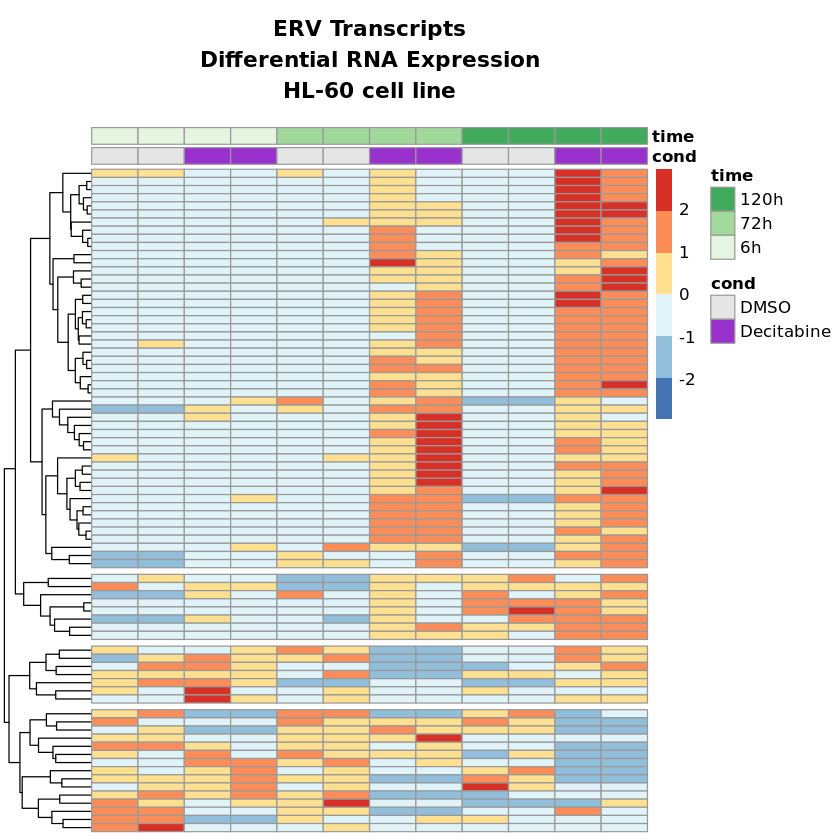

In [27]:
ncu[
    result_table %>% drop_na %>% 
        filter(
            (abs(hl60_6h_log2FC)  > 4 & hl60_6h_pvalue   < 0.001) |
            (abs(hl60_72h_log2FC) > 4 & hl60_72h_pvalue  < 0.001)|
            (abs(hl60_120h_log2FC)> 4 & hl60_120h_pvalue < 0.001) 
        ) %>% rownames
    ,
    # subset normalized counts
    colData[colData$line=='hl60',c('cond','time')] %>% arrange(time,cond) %>% rownames
] %>% data.frame %>% filter(rowSums(., na.rm = TRUE) > 0)  %>%
    # generate heatmap
    pheatmap(
        color = heat_colors, 
        show_colnames = F,
        show_rownames = F,
        cutree_rows = 4,
        main = 'ERV Transcripts\nDifferential RNA Expression\nHL-60 cell line',
        annotation = colData[colData$line=='hl60',c('cond','time')],
        cluster_cols = F, 
        scale = 'row',
        angle_col= 45,
        annotation_colors = ann_colors
) -> hm_hl60

# # https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
# pdf('tinat/heatmap_clustering_hl60.pdf', width=4, height=7)
# grid::grid.newpage()
# grid::grid.draw(hm_hl60$gtable)
# dev.off()

In [1]:
ncu

ERROR: Error in eval(expr, envir, enclos): object 'ncu' not found


In [ ]:
ncu[
    DAC_tx2gene$TXNAME
    ,
    # subset normalized counts
    colData %>% arrange(time,cond) %>% rownames
] %>% data.frame %>% filter(rowSums(., na.rm = TRUE) > 0)  %>%
    # generate heatmap
    pheatmap(
        color = heat_colors, 
        show_colnames = F,
        show_rownames = F,
        cutree_rows = 2,
        main = 'TINAT Transcripts\nDifferential RNA Expression\nAML cell lines',
        annotation = colData[,c('cond','time','line')],
        cluster_cols = T, 
        scale = 'row',
        angle_col= 45,
        annotation_colors = ann_colors
) -> hm_all

# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('tinat/heatmap_clustering_all.pdf', width=5, height=6)
grid::grid.newpage()
grid::grid.draw(hm_all$gtable)
dev.off()

In [ ]:
read.table('../meRIP-seq/radar_scallop/result.sig.txt',header=TRUE)$name

In [ ]:
ncu[
    # read.table('../meRIP-seq/radar_scallop/result.sig.txt',header=TRUE)$name
    DAC_tx2gene[DAC_tx2gene$GENEID == 'DAC.12-x1-0' | DAC_tx2gene$GENEID == 'DAC.252-x1-0',]$TXNAME
    ,
    # subset normalized counts
    colData %>% arrange(time,cond) %>% rownames
] %>% data.frame %>% filter(rowSums(., na.rm = TRUE) > 0) %>%
    # generate heatmap
    pheatmap(
        color = heat_colors,
        show_colnames = F,
        show_rownames = T,
        cutree_rows = 2,
        main = 'TINAT Transcripts\nDifferential RNA Expression\nAML cell lines',
        annotation = colData[,c('cond','time','line')],
        cluster_cols = T, 
        scale = 'row',
        angle_col= 45,
        annotation_colors = ann_colors
) -> hm_m6A

# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('tinat/heatmap_clustering_m6A.pdf', width=5, height=3)
grid::grid.newpage()
grid::grid.draw(hm_m6A$gtable)
dev.off()

In [ ]:
ncu[
    # read.table('../meRIP-seq/radar_scallop/result.sig.txt',header=TRUE)$name
    DAC_tx2gene[DAC_tx2gene$GENEID == 'DAC.12-x1-0' | DAC_tx2gene$GENEID == 'DAC.252-x1-0',]$TXNAME
    ,
    # subset normalized counts
    colData %>% filter(line == 'hl60') %>% arrange(time,cond) %>% rownames
] %>% data.frame %>% filter(rowSums(., na.rm = TRUE) > 0) %>%
    # generate heatmap
    pheatmap(
        color = heat_colors,
        show_colnames = F,
        show_rownames = T,
        cutree_rows = 2,
        main = 'TINAT Transcripts\nDifferential RNA Expression\nHL-60 cell line',
        annotation = colData[,c('cond','time')],
        cluster_cols = F, 
        scale = 'row',
        angle_col= 45,
        annotation_colors = ann_colors
) -> hm_m6A

# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('tinat/heatmap_clustering_hl60_m6A.pdf', width=5, height=2)
grid::grid.newpage()
grid::grid.draw(hm_m6A$gtable)
dev.off()

## Save results 

In [ ]:
# write all results into one file 
write.table(
    result_table[DAC_tx2gene$TXNAME,],
    'tinat/delta_exp_table.txt', quote = F, col.names=TRUE, row.names=TRUE,sep ='\t'
)

___
# Decitabine+rg3039 treatment RNA-Seq experiments 
in HL60 cell line


### load files

In [8]:
# %%R
files <- list.files(
    path='DAC-rg3039/RNA-seq/herv/quants', 
    pattern="quant.sf",full.names = TRUE, recursive=T
)
names(files) <- gsub("DAC-rg3039/RNA-seq/herv/quants/(\\S+)/quant.sf","\\1",files)

In [9]:
for (f in files){print(f)}

[1] "DAC-rg3039/RNA-seq/herv/quants/hl60_combination_1/quant.sf"
[1] "DAC-rg3039/RNA-seq/herv/quants/hl60_combination_2/quant.sf"
[1] "DAC-rg3039/RNA-seq/herv/quants/hl60_decitabine_1/quant.sf"
[1] "DAC-rg3039/RNA-seq/herv/quants/hl60_decitabine_2/quant.sf"
[1] "DAC-rg3039/RNA-seq/herv/quants/hl60_dmso_1/quant.sf"
[1] "DAC-rg3039/RNA-seq/herv/quants/hl60_dmso_2/quant.sf"
[1] "DAC-rg3039/RNA-seq/herv/quants/hl60_rg3039_1/quant.sf"
[1] "DAC-rg3039/RNA-seq/herv/quants/hl60_rg3039_2/quant.sf"


In [10]:
txi <- tximport(files, type = "salmon", txOut=T)

reading in files with read_tsv

1 
2 
3 
4 
5 
6 
7 
8 




In [11]:
# meta 
conds  <- factor(c(
    rep('Combination',2),rep('Decitabine',2),rep('DMSO',2),rep('rg3039',2)
), levels = c('DMSO','Decitabine','rg3039','Combination'))

reps <- factor(c(
    rep(c('rep1','rep2'),4)
),c('rep1','rep2'))

colData <- data.frame(
    cond=conds,
    reps=reps,
    row.names=colnames(txi$abundance),
    stringsAsFactors=FALSE
)
colData

,cond,reps
,<fct>,<fct>
hl60_combination_1,Combination,rep1
hl60_combination_2,Combination,rep2
hl60_decitabine_1,Decitabine,rep1
hl60_decitabine_2,Decitabine,rep2
hl60_dmso_1,DMSO,rep1
hl60_dmso_2,DMSO,rep2
hl60_rg3039_1,rg3039,rep1
hl60_rg3039_2,rg3039,rep2


In [12]:
dds0 <- DESeqDataSetFromTximport(txi, colData, ~cond)

using counts and average transcript lengths from tximport



In [13]:
dds1 <- estimateSizeFactors(dds0)

using 'avgTxLength' from assays(dds), correcting for library size



In [14]:
ncu <- counts(dds1, normalized=TRUE) %>% data.frame 

In [15]:
rld <- rlog(dds1)

In [16]:
# dds.pca <- DESeq(dds0, parallel=TRUE)
# # results 
# vsd <- varianceStabilizingTransformation(dds.pca)

# pca = plot_PCA(
#     vsd, 
#     colData(vsd), 
#     labels=colData(vsd)[,'cond'],
#     gr=c('cond'), title='Drug combination'
# )
# pca

In [17]:
# add dummy variables for drug treatment 
colData$Decitabine <- factor(c(
    rep('Treated',4),rep('NotTreated',4)
),c('NotTreated','Treated'))

colData$rg3039     <- factor(c(
    rep('Treated',2),rep('NotTreated',4),rep('Treated',2)
),c('NotTreated','Treated'))


colData

,cond,reps,Decitabine,rg3039
,<fct>,<fct>,<fct>,<fct>
hl60_combination_1,Combination,rep1,Treated,Treated
hl60_combination_2,Combination,rep2,Treated,Treated
hl60_decitabine_1,Decitabine,rep1,Treated,NotTreated
hl60_decitabine_2,Decitabine,rep2,Treated,NotTreated
hl60_dmso_1,DMSO,rep1,NotTreated,NotTreated
hl60_dmso_2,DMSO,rep2,NotTreated,NotTreated
hl60_rg3039_1,rg3039,rep1,NotTreated,Treated
hl60_rg3039_2,rg3039,rep2,NotTreated,Treated


In [18]:
dds_rep <- DESeqDataSetFromTximport(txi, colData, ~0+reps)

# Annova test
dds_rep <- DESeq(dds_rep, test="LRT", reduced=~1, parallel=TRUE)

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 18 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 18 workers



In [19]:
resultsNames(dds_rep)

[1] "repsrep1" "repsrep2"

In [20]:
# contrast design: rep2 vs rep1
res_rep2_vs_rep1  = results(dds_rep, contrast=list(
    c('repsrep2'),
    c('repsrep1')
),listValues=c(1,-1)) %>% data.frame

In [21]:
res_rep2_vs_rep1 <- res_rep2_vs_rep1 %>% replace(is.na(res_rep2_vs_rep1),0)

___

In [22]:
model.matrix(~0+Decitabine+rg3039+Decitabine*rg3039,colData)

,DecitabineNotTreated,DecitabineTreated,rg3039Treated,DecitabineTreated:rg3039Treated
hl60_combination_1,0,1,1,1
hl60_combination_2,0,1,1,1
hl60_decitabine_1,0,1,0,0
hl60_decitabine_2,0,1,0,0
hl60_dmso_1,1,0,0,0
hl60_dmso_2,1,0,0,0
hl60_rg3039_1,1,0,1,0
hl60_rg3039_2,1,0,1,0


In [23]:
dds2 <- DESeqDataSetFromTximport(txi, colData, ~0+Decitabine+rg3039+Decitabine*rg3039)

# Annova test
dds2 <- DESeq(dds2, test="LRT", reduced=~1, parallel=TRUE)


using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 18 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 18 workers



In [24]:
resultsNames(dds2)

[1] "DecitabineNotTreated"            "DecitabineTreated"              
[3] "rg3039Treated"                   "DecitabineTreated.rg3039Treated"

In [25]:
# contrast design: combination treatment vs dmso 
res_comb_vs_dmso  = results(dds2, contrast=list(
    c('DecitabineTreated','rg3039Treated','DecitabineTreated.rg3039Treated'),
    c('DecitabineNotTreated')
),listValues=c(1,-1)) %>% data.frame

In [26]:
# contrast design: decitabine treatment vs dmso 
res_decitabine_vs_dmso  = results(dds2, contrast=list(
    c('DecitabineTreated'),
    c('DecitabineNotTreated')
),listValues=c(1,-1)) %>% data.frame

___

In [27]:
model.matrix(~0+rg3039+Decitabine+Decitabine*rg3039,colData)

,rg3039NotTreated,rg3039Treated,DecitabineTreated,rg3039Treated:DecitabineTreated
hl60_combination_1,0,1,1,1
hl60_combination_2,0,1,1,1
hl60_decitabine_1,1,0,1,0
hl60_decitabine_2,1,0,1,0
hl60_dmso_1,1,0,0,0
hl60_dmso_2,1,0,0,0
hl60_rg3039_1,0,1,0,0
hl60_rg3039_2,0,1,0,0


In [28]:
dds3 <- DESeqDataSetFromTximport(txi, colData, ~0+rg3039+Decitabine+Decitabine*rg3039)

# Annova test
dds3 <- DESeq(dds3, test="LRT", reduced=~1, parallel=TRUE)

using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates: 18 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 18 workers



In [29]:
resultsNames(dds3)

[1] "rg3039NotTreated"                "rg3039Treated"                  
[3] "DecitabineTreated"               "rg3039Treated.DecitabineTreated"

In [30]:
# contrast design: combination treatment vs decitabine
res_comb_vs_decitabine  = results(dds3, contrast=list(
    c('rg3039Treated','rg3039Treated.DecitabineTreated'),
    c('rg3039NotTreated')
),listValues=c(1,-1)) %>% data.frame

In [31]:
# contrast design: rg3039 treatment vs dmso
res_rg3039_vs_dmso  = results(dds3, contrast=list(
    c('rg3039Treated'),
    c('rg3039NotTreated')
),listValues=c(1,-1)) %>% data.frame

In [32]:
# contrast design: combination treatment vs rg3039 
res_comb_vs_rg3039  = results(dds3, contrast=list(
    c('DecitabineTreated','rg3039Treated','rg3039Treated.DecitabineTreated'),
    c('rg3039NotTreated')
),listValues=c(1,-1)) %>% data.frame

___

In [33]:
RES = list(
    'comb_vs_dmso'=res_comb_vs_dmso, 
    'comb_vs_decitabine'=res_comb_vs_decitabine,
    'comb_vs_rg3039'=res_comb_vs_rg3039,
    'decitabine_vs_dmso'=res_decitabine_vs_dmso,
    'rg3039_vs_dmso'=res_rg3039_vs_dmso,
    'rep2_vs_rep1'=res_rep2_vs_rep1
)

### merge results

In [34]:
result_table <- cbind(
    RES[[1]] %>% select('log2FoldChange','pvalue') %>% 
        rename(comb_vs_dmso_log2FC=log2FoldChange,comb_vs_dmso_pvalue=pvalue),
    RES[[2]] %>% select('log2FoldChange','pvalue') %>% 
        rename(comb_vs_decitabine_log2FC=log2FoldChange,comb_vs_decitabine_pvalue=pvalue),
    RES[[3]] %>% select('log2FoldChange','pvalue') %>% 
        rename(comb_vs_rg3039_log2FC=log2FoldChange,comb_vs_rg3039_pvalue=pvalue),
    RES[[4]] %>% select('log2FoldChange','pvalue') %>% 
        rename(decitabine_vs_dmso_log2FC=log2FoldChange,decitabine_vs_dmso_pvalue=pvalue),
    RES[[5]] %>% select('log2FoldChange','pvalue') %>% 
        rename(rg3039_vs_dmso_log2FC=log2FoldChange,rg3039_vs_dmso_pvalue=pvalue),
    RES[[6]] %>% select('log2FoldChange','pvalue') %>% 
        rename(rep2_vs_rep1_log2FC=log2FoldChange,rep2_vs_rep1_pvalue=pvalue)
    
) %>% drop_na

result_table <- result_table %>% replace(is.na(result_table),0)

In [35]:
result_table <- result_table %>% rownames_to_column('fullname') %>% 
        dplyr::rowwise() %>% dplyr::mutate(name = strsplit(fullname, split=":")[[1]][2]) %>% 
        data.frame %>%
        # filter(!duplicated(name_new)) %>%
    column_to_rownames('fullname') #%>% select(-name) 

In [47]:
write_Result(
    ncu,'DAC-rg3039/RNA-seq/herv/deseq2_norm.txt',col=T,row=T
)

In [50]:
write_Result(
    result_table,'DAC-rg3039/RNA-seq/herv/result_table.txt',col=T,row=T
)

In [48]:
# %>% group_by(name) %>% tally() %>% filter(n>50)
# # dplyr::filter(name %in% 'LTR67B')

## Plots

In [10]:
result_table = read.table(
    'DAC-rg3039/RNA-seq/herv/result_table.txt'
)

### scatter plot

In [76]:
prep_scatter <- function(p){
    p + 
    geom_point(
        data          = result_table %>% dplyr::filter(name %in% labels$name),
        colour='#3cedf0',size = 2, alpha = 1, show.legend = FALSE) + 
    geom_point(
        data          = result_table[labels %>% rownames,],
        shape = 21, colour = "#386cb0", fill = "#3cedf0", size = 2, stroke = 1,
        alpha = 1, show.legend = FALSE) + 
    geom_text_repel(
        data          = result_table[labels %>% rownames,],
        nudge_y       = 1.1 ,#- subset(dat, mpg > 30)$mpg,
        segment.size  = .2,
        size = 4,
        segment.color = "grey50",
        direction     = "x"
    ) +
    theme_bw(30) +
    theme(
        text=element_text(size=14),
        panel.background = element_rect(colour = "black"), 
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.ticks = element_line(size = .5)
        
    ) -> p
    return (p)
}

In [77]:
labels = result_table %>%
    dplyr::filter(
        (comb_vs_dmso_log2FC > 8 & comb_vs_dmso_log2FC  > 8) 
        &
        (abs(decitabine_vs_dmso_log2FC) < 0.8 & abs(rg3039_vs_dmso_log2FC) < 0.8)
        # &
        # (name %in% (result_table %>% 
        #      group_by(name) %>% tally() %>% filter(n<100) %>% 
        #      column_to_rownames('name') %>% rownames
        # ))
    ) %>% select(name)

# labels = result_table['ERV:HERVL+MLT2B3:<hg38:chr16:29002652-29008043:F>:1346575',]

In [78]:
result_table$label = ''

result_table[labels %>% rownames,]$label = 'PABL_A chr9:9641512-9642657'

In [79]:
result_table %>% ggplot + 
    aes(decitabine_vs_dmso_log2FC, comb_vs_dmso_log2FC, label = label) + 
    # "#fdb462", "#7fc97f
    geom_point(colour='gray90',size = 2, alpha = 1, show.legend = FALSE) + 
    xlab('log2FC\nDecitabine vs DMSO') + 
    ylab('log2FC\nCombination vs DMSO') + 
    theme_Publication() + 
    labs(colour = "") -> p1 


In [80]:
result_table %>% ggplot + 
    aes(rg3039_vs_dmso_log2FC, comb_vs_dmso_log2FC, label = label) + 
    # "#fdb462", "#7fc97f
    geom_point(colour='gray90',size = 2, alpha = 1, show.legend = FALSE) + 
    xlab('log2FC\nRG3039 vs DMSO') + 
    ylab('log2FC\nCombination vs DMSO') +     
    theme_Publication() + 
    labs(colour = "") -> p2
    # scale_y_continuous(breaks=NULL) 

In [81]:
# (prep_scatter(p1) + theme_Publication()) + (prep_scatter(p2) + theme_Publication())
# # & theme(plot.margin = unit(c(0.1,0.1,0.1,0.1), "cm"))

In [82]:
ggsave('DAC-rg3039/RNA-seq/herv/DAC-rg3039-ERV-expression-scatter.eps',
       plot=(
           prep_scatter(p1) + theme_Publication() + theme(axis.title = element_text(face = "plain", size = rel(0.8)))
       ) + (
           prep_scatter(p2) + theme_Publication() + theme(axis.title = element_text(face = "plain", size = rel(0.8)))
       ),       
       width = 10, height = 5, device='eps')

https://herv.img.cas.cz/entities/3669486

In [137]:
plot_gene_counts(
    dds2,
    'ERV:PABL_A:<hg38:chr9:9641512-9642657:F>:3669486',
    'PABL_A\nchr9:9641512-9642657',
    'cond'
) + 
xlab('') + 
theme(
    legend.position = "none",
    axis.title = element_text(face = "plain", size=16),
    axis.text.x = element_text(angle = 45,hjust=1),
    text=element_text(size=16),
    plot.title = element_text(face = "plain", size=16),
    
) -> p3

In [140]:
ggsave('DAC-rg3039/RNA-seq/herv/DAC-rg3039-ERV-expression-counts.pdf',
       plot=p3,
       width = 4, height = 5)

geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?



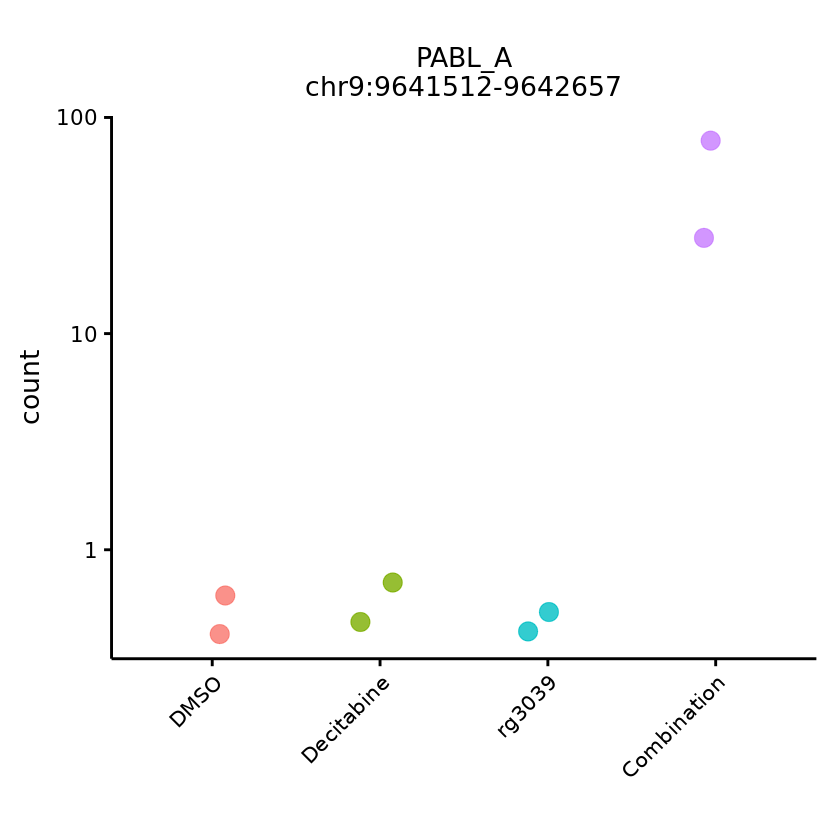

In [141]:
p3

### heatmap

In [ ]:
dim(ncu)[1] - sum(rowSums(ncu) == 0)

In [ ]:
heat_colors <- brewer.pal(n = 6, name = "RdYlBu") %>% rev
paired <- brewer.pal(n = 10, name = "Paired")


In [ ]:
ann_colors = list(
    cond = c('DMSO'= paired[1], 'Decitabine'=paired[3], 'rg3039'=paired[9],'Combination'=paired[10])
)

In [ ]:
ncu[
    # select genes based on abs(log2FC) and pvalue
    result_table %>%
        dplyr::filter((abs(rep2_vs_rep1_log2FC) < 1 & rep2_vs_rep1_pvalue > 0.9) & (
            (abs(comb_vs_dmso_log2FC) > 1 & comb_vs_dmso_pvalue  < 0.05) |
            (abs(comb_vs_decitabine_log2FC) > 1 & comb_vs_decitabine_pvalue  < 0.05) |
            (abs(comb_vs_rg3039_log2FC) > 1 & comb_vs_rg3039_pvalue  < 0.05) |
            (abs(decitabine_vs_dmso_log2FC) > 1 & decitabine_vs_dmso_pvalue  < 0.05) |
            (abs(rg3039_vs_dmso_log2FC) > 1 & rg3039_vs_dmso_pvalue  < 0.05)
        )

        #     (
        #     (abs(comb_vs_decitabine_log2FC) > 1 & comb_vs_decitabine_pvalue  < 0.01) |
        #     (abs(comb_vs_dmso_log2FC) > 1 & comb_vs_dmso_pvalue  < 0.01)
        # ) & (abs(decitabine_vs_dmso_log2FC) < 0.8 & abs(rg3039_vs_dmso_log2FC) < 0.8)
            
        ) %>% 
    rownames
    , 
    # subset normalized counts
    colData %>% arrange(cond) %>% rownames
] %>% 
rownames_to_column('name') %>% 
        dplyr::rowwise() %>% dplyr::mutate(name_new = strsplit(name, split=":")[[1]][2]) %>% 
        data.frame %>%
        filter(!duplicated(name_new)) %>%
    column_to_rownames('name_new') %>% select(-name) -> ncu1

ncu1 %>% dim

ncu1 %>%
    # generate heatmap
    pheatmap(
        color = heat_colors, 
        show_colnames = F,
        show_rownames = T,
        cutree_rows = 5,
        main = 'Decitabine+rg3039 drug combination\nendogenous retrovirus (ERV)',
        annotation = colData %>% arrange(cond) %>% select(cond),
        cluster_cols = F, 
        scale = 'row',
        angle_col= 45,
        annotation_colors = ann_colors
) -> hm

# https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
pdf('DAC-rg3039/RNA-seq/herv/heatmap_clustering.pdf', width=7, height=50)
grid::grid.newpage()
grid::grid.draw(hm$gtable)
dev.off()

In [ ]:
RES %>% names

In [90]:
data.frame(assay(rld))[
    # select genes based on abs(log2FC) and pvalue
    result_table %>%
        dplyr::filter(
            name %in% labels$name
            # (abs(comb_vs_decitabine_log2FC) > 5 & comb_vs_decitabine_log2FC  < 0.01) 
            # &
            # (abs(decitabine_vs_dmso_log2FC) < 1 & abs(rg3039_vs_dmso_log2FC) < 1)
            # &
            # (name %in% (result_table %>% 
            #      group_by(name) %>% tally() %>% filter(n<100) %>% 
            #      column_to_rownames('name') %>% rownames
            # ))

            (abs(rep2_vs_rep1_log2FC) < 1 & rep2_vs_rep1_pvalue > 0.9) & (
            (abs(comb_vs_dmso_log2FC) > 1 & comb_vs_dmso_pvalue  < 0.05) |
            (abs(comb_vs_decitabine_log2FC) > 1 & comb_vs_decitabine_pvalue  < 0.05) |
            (abs(comb_vs_rg3039_log2FC) > 1 & comb_vs_rg3039_pvalue  < 0.05) |
            (abs(decitabine_vs_dmso_log2FC) > 1 & decitabine_vs_dmso_pvalue  < 0.05) |
            (abs(rg3039_vs_dmso_log2FC) > 1 & rg3039_vs_dmso_pvalue  < 0.05)
        )

        #     (abs(comb_vs_decitabine_log2FC) > 1 & comb_vs_decitabine_pvalue  < 0.01) |
        #     (abs(comb_vs_dmso_log2FC) > 1 & comb_vs_dmso_pvalue  < 0.01)
        # ) & (abs(decitabine_vs_dmso_log2FC) < 0.8 & abs(rg3039_vs_dmso_log2FC) < 0.8)
        ) %>% 
    rownames
    , 
    # subset normalized counts
    colData %>% arrange(cond) %>% rownames
] -> rld1
# %>% 
# rownames_to_column('name') %>% 
#         dplyr::rowwise() %>% dplyr::mutate(name_new = strsplit(name, split=":")[[1]][2]) %>% 
#         data.frame %>%
#         filter(!duplicated(name_new)) %>%
#     column_to_rownames('name_new') %>% 
# select(-name) 

rld1 %>%
    # generate heatmap
    pheatmap(
        color = heat_colors, 
        show_colnames = F,
        show_rownames = T,
        cutree_rows = 2,
        main = 'Decitabine+rg3039 drug combination\nendogenous retrovirus (ERV)',
        annotation = colData %>% arrange(cond) %>% select(cond),
        cluster_cols = F, 
        # scale = 'row',
        angle_col= 45,
        annotation_colors = ann_colors
) -> hm

# # https://stackoverflow.com/questions/43051525/how-to-draw-pheatmap-plot-to-screen-and-also-save-to-file
# pdf('DAC-rg3039/RNA-seq/herv/heatmap_clustering_counts.pdf', width=7, height=50)
# grid::grid.newpage()
# grid::grid.draw(hm$gtable)
# dev.off()

ERROR: Error in (function (cond) : error in evaluating the argument 'x' in selecting a method for function 'rownames': Problem with `filter()` input `..1`.
[34mℹ[39m Input `..1` is `&...`.
[31m✖[39m error in evaluating the argument 'table' in selecting a method for function '%in%': attempt to apply non-function


### 

- ERVL-E 
    - https://herv.img.cas.cz/elements/72
    - https://dfam.org/family/DF0000120/summary

In [316]:
ERVL.E='ERV:ERVL−E:<hg38:chr17:74540590−74541302:F>:1510718'

In [356]:
ncu1 = ncu %>% rownames_to_column('name') %>% 
        dplyr::rowwise() %>% dplyr::mutate(name_new = strsplit(name, split=":")[[1]][2]) %>% 
        data.frame %>%
        # filter(!duplicated(name_new)) %>%
        filter(name_new == 'ERVL−E')

In [384]:
ncu1 %>% 
    # select(-name) %>% 
    head

,hl60_dmso_1,hl60_dmso_2,hl60_decitabine_1,hl60_decitabine_2,hl60_rg3039_1,hl60_rg3039_2,hl60_combination_1,hl60_combination_2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MLT1K,34.42672,10.45756,0.0000,43.64121,29.75808,17.27775,0.00000,0.000000
HUERS-P3+LTR9,1266.58310,1776.04161,905.4203,1075.06389,1207.32785,1028.02595,726.40144,699.709011
MER9a1,32.02486,95.86093,101.0031,45.77005,38.26039,36.12620,0.00000,9.745251
LTR72,102.47954,118.51897,168.3384,192.65996,178.54848,104.45183,344.61476,294.306576
MER21B,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,30.97661,11.044618
MLT1A,225.77524,207.40820,296.9971,288.45774,218.22593,190.84057,470.07002,400.204968


# Session Info

In [108]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data_gilbert/home/aarab/anaconda3/envs/deseq2/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] corrplot_0.92               Hmisc_4.6-0                
 [3] Formula_1.2-4               survival_3.2-13            
 [5] lattice_0.20-45             ggcorrplot_0.1.3           
 [7] ggthemes_4.2.4              scales_1.1.1               
 [9] RColorBrewer_1.1-

In [391]:
date()

[1] "Fri Nov 11 13:22:12 2022"